# Spotify's worldwide daily top songs 
### Introduction
The idea of this short kernel is to explore the "Spotify's Worldwide Daily Song Ranking" Dataset, mainly with the goal of getting some insights on the most popular songs trends and characteristics. 
More specifically, I am wondering if there are some 'families of trends'. For example, an highly-anticipated song might have the peak in the few days after the release and then decrease exponentially soon after. On the other hand, some song (maybe of less-known authors?) might start lower and gradually increase in the following months or so.

Let's start straightaway looking at the dataset:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kmedoids
from sklearn.metrics import silhouette_score
from scipy.stats import entropy
from scipy import stats
import chartify

#Load the dataset and print its basic characteristics:

df = pd.read_csv('data.csv')
initial_entries_number = df.shape[0]
print("Features:",df.columns.values) 
print("Total number of entries:",initial_entries_number)
print("Some NA values in the features:", df.columns[df.isnull().any()].values)

Loading BokehJS ...

Features: ['Position' 'Track Name' 'Artist' 'Streams' 'URL' 'Date' 'Region']
Total number of entries: 3441197
Some NA values in the features: ['Track Name' 'Artist' 'URL']


In [2]:
#Clean the data from NaNs:

df.dropna(inplace=True)
entries_number = df.shape[0]
diff = initial_entries_number-entries_number
print("Removed a total of",diff,"rows","(",diff/initial_entries_number,"%)")

Removed a total of 657 rows ( 0.00019092193791869514 %)


Since the missing datas where in very few entries, we can remove them without any problem.

I suppose that the number of streams remains more or less constant throughout the whole year, thus we plot such trend to check if the dataset is somehow skewed or it presents some suspicious number due to some missing data (namely a missing country for a day). 
I think it is something worth checking out as this might significantly affect some trend curves

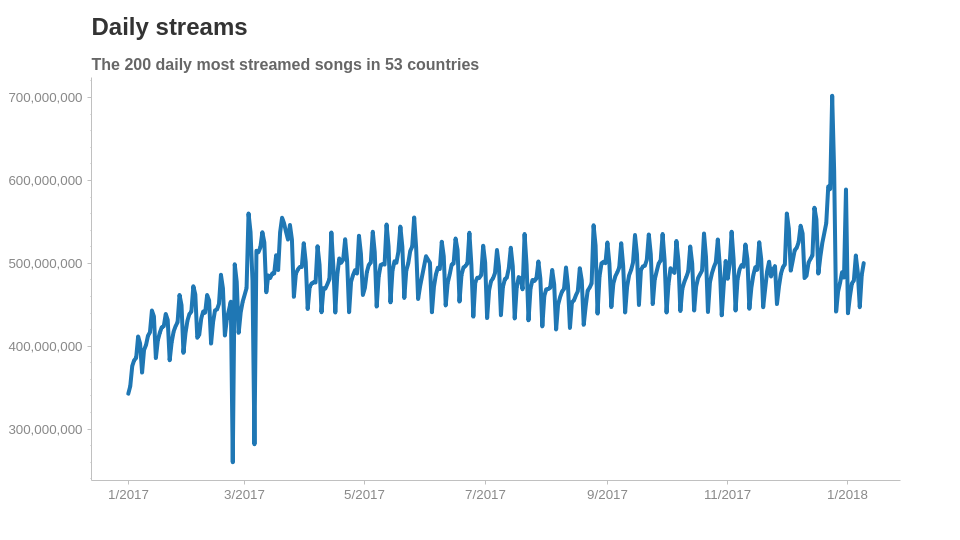

In [3]:
# Sum grouped by date
grouped_by_date = (
    df.groupby('Date').sum()
    .reset_index()  )

# Plot the data
ch = chartify.Chart(blank_labels=True, x_axis_type='datetime')
ch.set_title("Daily streams")
ch.set_subtitle("The 200 daily most streamed songs in 53 countries")
ch.plot.line(
    # Data must be sorted by x column
    data_frame=grouped_by_date.sort_values('Date'),
    x_column='Date',
    y_column='Streams')
ch.show("png")

Apart from two strange single-day dips around March and a lower than expected January, the graph fluctuates around an average constant value, with a quite strong weekly pattern.

Might be of further interest also looking at which are the most popular artists. I suspect that in these cases the different tracks of the same singer might have some sort of stronger correlation.

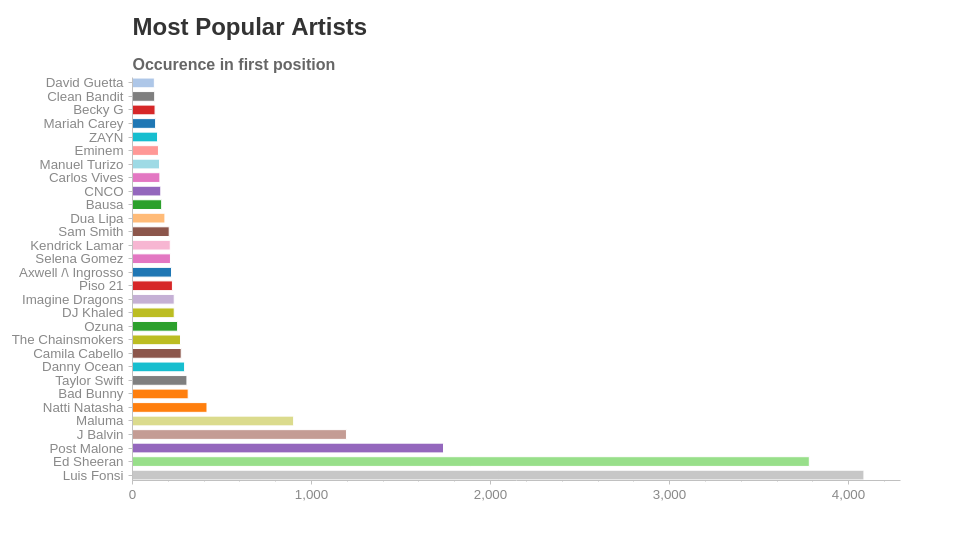

In [4]:
top_artist = df.loc[df['Position'] == 1, 'Artist'].value_counts()
top_artist = top_artist.to_frame().reset_index()
top_artist.columns = ['Artist', 'count1']

top_artist = top_artist.iloc[:30,:]

ch = chartify.Chart(blank_labels=True, y_axis_type='categorical')
ch.set_title("Most Popular Artists")
ch.set_subtitle("Occurence in first position")
ch.plot.bar(
    data_frame=top_artist,
    categorical_columns='Artist',
    numeric_column='count1',
    color_column='Artist')
ch.show("png")


The distribution seems to follow an exponential trend. Luis Fonsi with Ed Sheeran dominate the chart, and then the count quickly decreases to around 100, where we find a wide moltitude of different artists.

Although the artists reach similar numbers, a closer look to their song trends reveal a completely different story:

/home/andrea/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


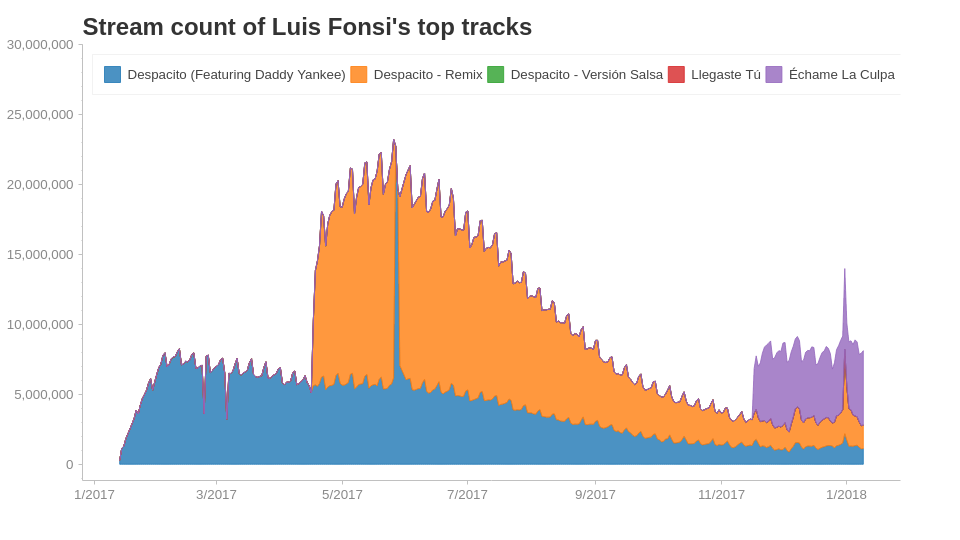

In [5]:

df_LF = df.loc[df['Artist'] == 'Luis Fonsi',:]


df_LF["Date"] = pd.to_datetime(df_LF["Date"])


total_quantity_by_song_and_date = (df_LF.groupby(
    [df_LF['Date'] , 'Track Name'])['Streams'].sum()
    .reset_index().rename(columns={'Date': 'month'})
    .sort_values('month'))


# Plot the data
ch = chartify.Chart(blank_labels=True, x_axis_type='datetime')
ch.set_title("Stream count of Luis Fonsi's top tracks")
ch.plot.area(
    data_frame=total_quantity_by_song_and_date,
    x_column='month',
    y_column='Streams',
    color_column='Track Name',
    stacked=True)
ch.axes.set_yaxis_range(end = 30000000)
ch.show("png")

/home/andrea/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/andrea/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


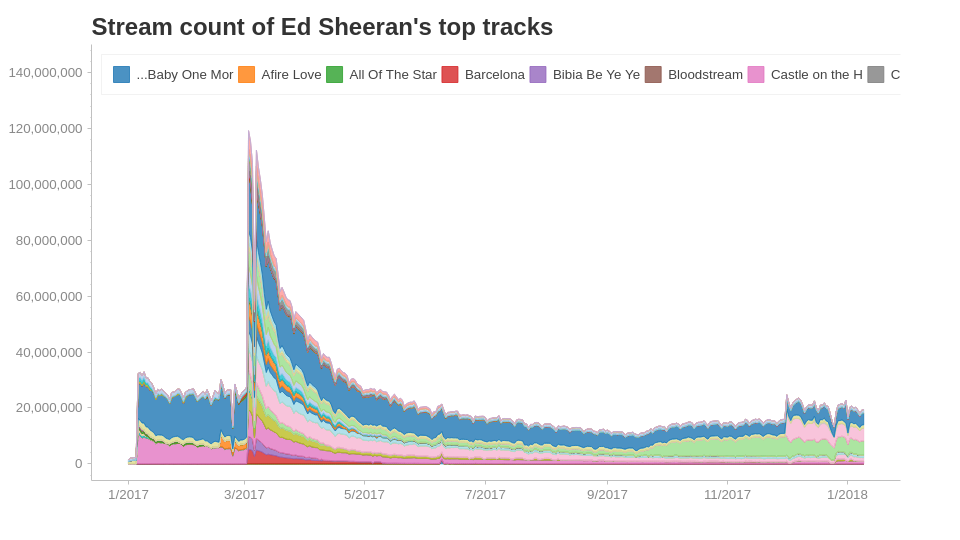

In [6]:
df_ED = df.loc[df['Artist'] == 'Ed Sheeran',:]

df_ED["Date"] = pd.to_datetime(df_ED["Date"])
#Shorten song names
df_ED["Track Name"] = df_ED["Track Name"].apply(lambda x: x[0:15])


total_quantity_by_song_and_date = (df_ED.groupby(
    [df_ED['Date'] , 'Track Name'])['Streams'].sum()
    .reset_index().rename(columns={'Date': 'month'})
    .sort_values('month'))

# Plot the data
ch = chartify.Chart(blank_labels=True, x_axis_type='datetime')
ch.set_title("Stream count of Ed Sheeran's top tracks")
ch.plot.area(
    data_frame=total_quantity_by_song_and_date,
    x_column='month',
    y_column='Streams',
    color_column='Track Name',
    stacked=True)
ch.axes.set_yaxis_range(end = 150000000)
ch.show("png")

While Luis Fonsi's popularity has to be attributed almost completely to the song Despacito (either the original or remix version), Ed Sheerhan's success has to be attributed to a wider range of traks. 
The peak in the figure is due to the release of its third album on the third of March.

It is now time for the main point of this kernel, that is investigating the different trends of the songs.
As I think that different regions have different internal dynamics and behaviours, I am afraid that the same song has different trends in different places, thus taking the overall average would smooth out the curves loosing much of the diversity in trends. For this reason I focus the analysis on one of the biggest region (for stream number), that is the USA.
Do I got so far any strong evidence of my assumption? Not really, but I prefer to now procede in such way as it is safer, and later I can repeat the investigation for the whole world.

I thus now procede to get the stream count curve for each song that reached the top 4 in the USA. More in specific, for each track only the first 150 days after the release are recorded (having a fixed length makes it easier to compare the curves). In the (not so common) case that the track is not in the top200 anymore, the stream count is simply put to zero for the remaining days. The latter choice is given by the idea that such value, if the song exited the top200, must be already quite low. In fact we'll see it is not always the case. It is an odd phenomenon and it makes me wonder if there is some problem with the dataset, namely that the song has been later stored with a (even just slightly) different name.

After that, I want to get how "different" two curves are. 
How to get such measure? It depends on what the definition of "different" is. I tried three different measures:
- Pearson correlation coefficient
- Mean squared error
- Kullback-Leibler Divergence (average of the two possibilities, as it is not symmetrical)

All three the measures implies different definition of dissimilarity. The Pearson correlation measures the linear correlation between two variables. It is invariant to the size of the curves or to translations. Thus, the curves y=x and y=2x +1 would be considered as identical. 
Another alternatives is the Kullback-Leibler Divergence (aka relative entropy), which sees the two curves as probabilitiy distribution and indicates the amount of information gain. While it is a different and interisting approach, in the case of one of the two curves approaching zero while the other is still with visible value, this measure explodes (due to the factor P(i)/Q(i) with Q(i) close to zero). 
Finally, I opted to continue the analysis using the MSE, with the curves normalized between [0,1], so to be comparable effectively with this standard measure which gave interpretable results.


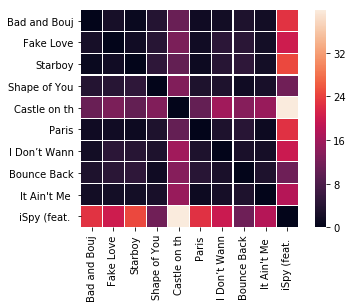

In [7]:
from utils import *
import seaborn as sns
    
#Get info of all the songs who got into the top4 in USA:
us_song = df.loc[df.Region == 'us',:]
df_stream = us_song[['Date', 'Track Name', 'Streams', 'Position']]
df_stream = df_stream.groupby(['Date', 'Track Name']).first().reset_index()
stream_num = df_stream.pivot(index = 'Date', columns = 'Track Name', values = 'Streams')
pos_num = df_stream.pivot(index = 'Date', columns = 'Track Name', values = 'Position')
us_unique_song = us_song['Track Name'].loc[us_song.Position < 4].unique()

n_songs = len(us_unique_song)

#Get all the trends:
songs_curve = []
for name in us_unique_song:
    trend = get_streams_and_position(name, stream_num, pos_num)
    v =standardize_serie(trend)
    songs_curve.append(v)
#    plt.plot(range(len(v)), v)    
#plt.show()

#Create distance matrix D:
D = np.zeros([n_songs,n_songs])
for i in range(n_songs):
    for jj in range(1,n_songs-i) :
        j = jj+i
#        D[i,j] = stats.pearsonr(songs_curve[i],songs_curve[j])[0]
        D[i,j] = np.sum(np.square(songs_curve[i] - songs_curve[j]))
#        D[i,j] = (entropy(songs_curve[i],songs_curve[j])+entropy(songs_curve[j],songs_curve[i]))/2
        D[j,i] = D[i,j]

#Plot heatmap:
disp_n = 10
ax = sns.heatmap(D[:disp_n,:disp_n], linewidth=0.1, square = True,xticklabels=True,yticklabels=True)
#Shorten name
short_name = [elem[:12] for elem in us_unique_song[:disp_n] ]
ax.set_yticklabels(short_name, rotation =0)
ax.set_xticklabels(short_name, rotation =90)
plt.show()


We have now a distance matrix describing how similar two songs trends are similar.
Now, we would like to use some unsupervised learning approach to identify different "faimilies" of behaviour. 
There are several clustering techniques available, however our range tightens as we only have the distance between the songs, while the major part of these algoritms (f.e. Gaussian Mixture Model or k-means) require that each entity (i.e. song) is identified as a point in a high-dimension space. 
For these reasons, I've chosen PAM, i.e. partition around medoids, a clustering algorithm similar to the famous k-means which only requires the distance matrix and usually brings good results (although one could argue that in unsupervised learning "good" is an ambiguous term).   
Due to the intrinsic stochastic component of the algorithm, given by how we do initialize the medoids, I run the algorithm multiple times and get the best result.

Here, I judge the quality of the clusters obtained with the Silhouette measure, which gives an output bound between -1 and 1. The higher the value the higher the 'quality'.
Of course it is possible to change the number of clusters that we want to detect. I am here showing the results with four, but it is just an example. We should then try with different values and compare the results.

Silhouette value: 0.6117928147952115


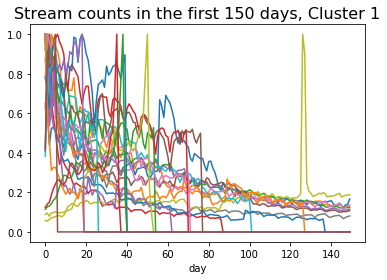

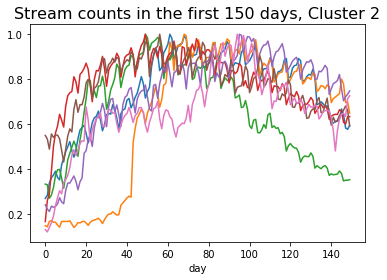

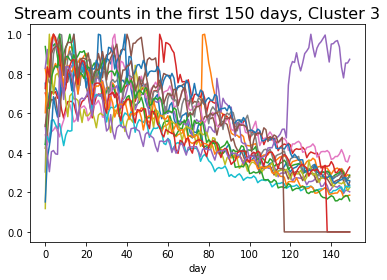

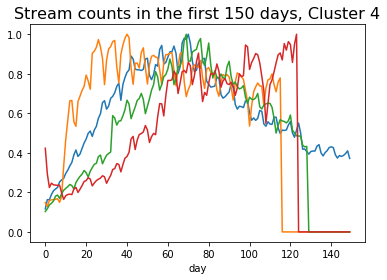

In [8]:

iterations = 20
n_cluster = 4

M_best, C_best = [], []
s_best = -1
for i in range(iterations):
    # Perform PAM:    
    M, C = kmedoids.kMedoids(D, n_cluster)     
    #Compute Silhouette measure to check consistency within clusters of data
    mm = np.zeros(len(songs_curve) )
    for i in range(len(C)):
        mm[C[i]] = i
    s = silhouette_score(D,mm,metric = "precomputed")
    if s > s_best:
        s_best = s
        M_best = M
        C_best = C
        
print("Silhouette value:",s_best) 

#Plot curves for clusters:
C = C_best
M = M_best
v_v = []
for cluster_index, cluster in enumerate(C):
    _, v = plt.subplots()
    str_title = 'Stream counts in the first 150 days, Cluster '+str(cluster_index+1)
    plt.title(str_title, fontsize=16)
    v.set_xlabel('day')
    for i in C[cluster_index]:
        v.plot(range(len(songs_curve[i])), songs_curve[i])  


    
plt.show()

Yep, the graphs look messy, but what did you expect? However, we can spot the odd interruption of the majority of the curves who do not have the record for the 150 days. The assumption previously made is thus probably wrong and I guess it should be better to remove such tracks.

To better visualize the different general trends of each cluster let's spend some time plotting the curves in a more meaningful way:

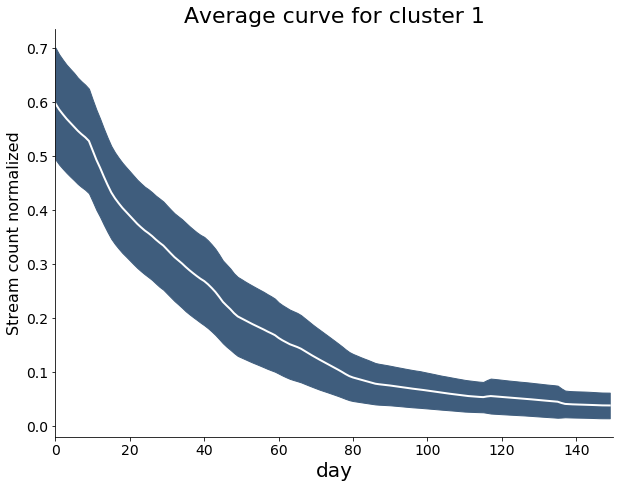

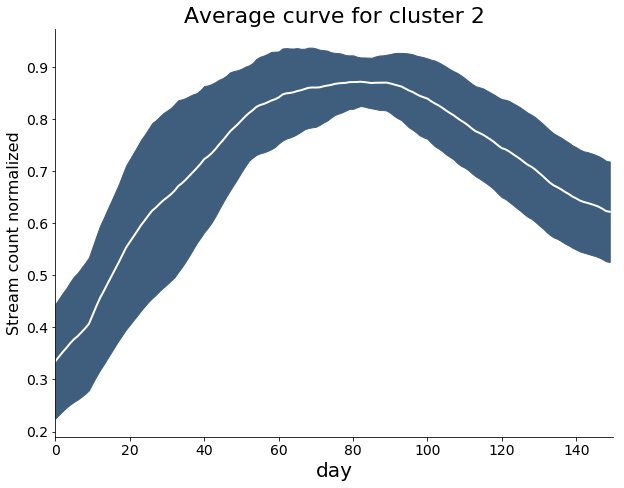

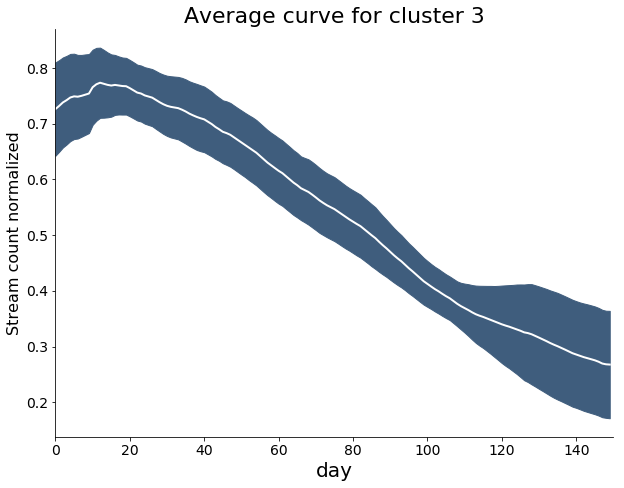

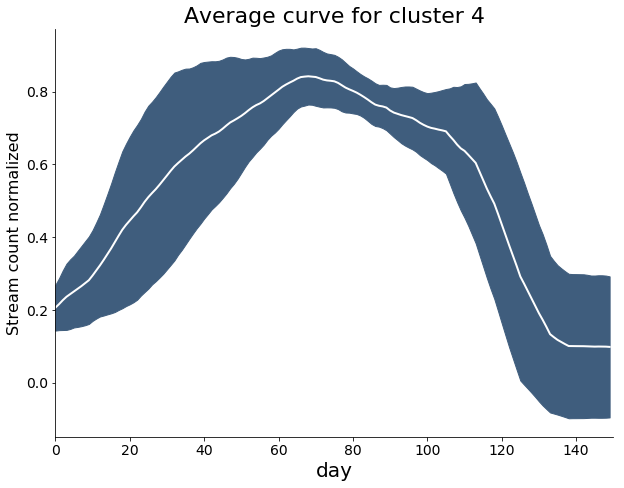

In [9]:
from scipy.stats import sem  


# This function takes an array of numbers and smoothes them out.  
def sliding_mean(data_array, window=5):  
    data_array = np.array(data_array)  
    new_list = []  
    for i in range(len(data_array)):  
        indices = range(max(i - window + 1, 0),  
                        min(i + window + 1, len(data_array)))  
        avg = 0  
        for j in indices:  
            avg += data_array[j]  
        avg /= float(len(indices))  
        new_list.append(avg)  
          
    return np.array(new_list)  

#Plot the average curve for each cluster:
for cluster_index in range(0,n_cluster):

    #Prepare the dataset:
    usz = []
    for i in C[cluster_index]:
        acci = pd.DataFrame(songs_curve[i])
        acci["day"] = np.array(range(150))
        usz.append(acci)
    prepared_data =  pd.concat(usz)
    prepared_data.rename(columns={0:"year"},inplace=True )


    years = prepared_data.groupby("day").year.mean().keys()  
    mean_PlyCount = sliding_mean(prepared_data.groupby("day").year.mean().values,  
                                 window=10)  
    sem_PlyCount = sliding_mean(prepared_data.groupby("day").year.apply(sem).mul(1.96).values,  
                                window=10)  

    plt.figure(figsize=(10, 7.5))  

    # Remove the plot frame lines
    ax = plt.subplot(111)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  

    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()  

    plt.xlim(0,150)  

    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14)  

    plt.ylabel("Stream count normalized", fontsize=16)  

    plt.fill_between(years, mean_PlyCount - sem_PlyCount,  
                     mean_PlyCount + sem_PlyCount, color="#3F5D7D")  

    # Plot the means as a white line in between the error bars.   
    plt.plot(years, mean_PlyCount, color="white", lw=2)  

    title_plot = "Average curve for cluster "+str(cluster_index+1)
    plt.title(title_plot, fontsize=22)  

    plt.xlabel("day", fontsize=20)  

    plt.show()

As we could already guess in the previous graphs, it is now clear how there are completely different popularity trends. In particular, we have a family of curves that closely resemble an exponential decay, another one that sees its peak after around two weeks and then decrease linearly, plus two slightly more complex trends. 

Assuming now that these clusters are meaningful (i.e. they reflect different real popularity behaviour and they are not just an artifact), we want to know if there are any characteristic feature of the song/author which strongly affects its trend. Since our starting dataset does not contain these features, we have to use another dataset, the "Top Spotify Tracks of 2017". 

In [10]:
df_feature = pd.read_csv('featuresdf.csv')
print("Song characteristics:\n",list(df_feature.columns))

#Get the features of the songs per cluster.
#As this dataset only contains the top 100 songs in 2017, not all the songs of the original dataset are present
cluster_id = 0
songs_names_cluster = us_unique_song[mm==cluster_id]
k1 = df_feature[df_feature['name'].isin(list(songs_names_cluster))]

cluster_id = 1
songs_names_cluster = us_unique_song[mm==cluster_id]
k2 = df_feature[df_feature['name'].isin(list(songs_names_cluster))]

cluster_id = 2
songs_names_cluster = us_unique_song[mm==cluster_id]
k3 = df_feature[df_feature['name'].isin(list(songs_names_cluster))]

cluster_id = 3
songs_names_cluster = us_unique_song[mm==cluster_id]
k4 = df_feature[df_feature['name'].isin(list(songs_names_cluster))]

Song characteristics:
 ['id', 'name', 'artists', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']


We have a wide range of features describing the song, we want to know understand if any of those characteristics can be a good indicator of the song trend. 
In this case, given the small dataset plus the goal of an interpretable and simple result, I don't think it is a good idea to use complex Machine Learning model. Rather, I am using the good old ANOVA test on each dimension (i.e. feature) to assess how distinct our clusters are.\n 
Although such tool is simpler (and older), it still relies on certain assumption, namely homoscedasticity and Gaussian distributed points. 


Max F-value:  1.8758953345189744
Feature:  acousticness


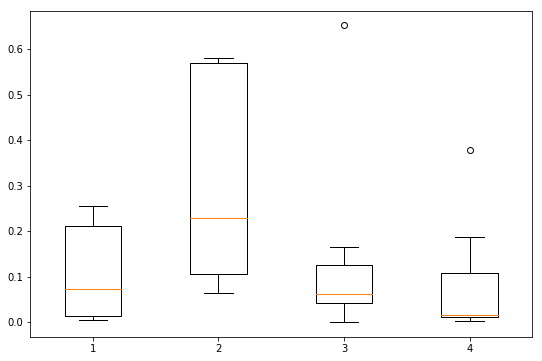

In [11]:
from scipy.stats import f_oneway

# Remove non-numeric features
list_features = list(df_feature.columns)
list_features.remove("id")
list_features.remove("name")
list_features.remove("artists")
list_features.remove("time_signature")

#Get F-value for each of the remaining features
f_statics = [(f_oneway(k1[feature],k2[feature], k3[feature], k4[feature]))[0] for feature in list_features]

#Find the highest F-value
max_f = max(f_statics)
index_max = [i for i, j in enumerate(f_statics) if j == max_f]
feature = list_features[index_max[0]]

print("Max F-value: ", max_f )
print("Feature: ", feature)

#Plot boxplot for such feature:
data_plot = [np.array(k1[feature]),np.array(k2[feature]),np.array(k3[feature]),np.array(k4[feature])]

fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(data_plot)
plt.show()

Running the PAM clustering algorithm different times, even getting similar clusters the above F-values keep changing and there is not a clear 'winner'. Furthermore, also from the box plot we can see how the selected feature does not look to be really discriminant. I thus think that there is no single (haven't explored the possibility of a combination of them) characteristcs that is a strong indicator of that song's trend.

Maybe, the popularity of the author might be correlated to the song trend. Let's then try to repeat the same procedure for the popularity of the songs artists:

/home/andrea/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


F-value: F_onewayResult(statistic=1.1127980054532922, pvalue=0.3529550245261105)


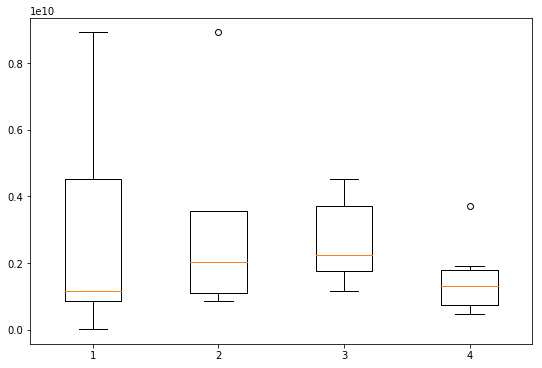

In [13]:
from itertools import compress
def get_total_streams_author(df, name_author):

    df_LF = df.loc[df['Artist'] == name_author,:]

    df_LF["Date"] = pd.to_datetime(df_LF["Date"])

    total_quantity_by_song_and_date = (df_LF.groupby(
        [df_LF['Date'] , 'Track Name'])['Streams'].sum()
        .reset_index().rename(columns={'Date': 'month'})
        .sort_values('month'))

    return total_quantity_by_song_and_date
    
song_author_popularity = []    
for song in us_unique_song:
    res = df.loc[df["Track Name"]==song]
    name_author = list(res["Artist"])[0]
    t = get_total_streams_author(df, name_author)
    stream_author = t["Streams"].sum()
    song_author_popularity.append(stream_author)
    
    
k1 = list(compress(song_author_popularity, mm==0))
k2 = list(compress(song_author_popularity, mm==1))
k3 = list(compress(song_author_popularity, mm==2))
k4 = list(compress(song_author_popularity, mm==3))
print("F-value:",f_oneway(k1,k2,k3,k4) )

data_plot = [k1,k2,k3,k4]

fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(data_plot)
plt.show()    

We get an F-value similar to the ones before. I would not thus say that the popularity of an author strictly influences the trend of the curve. 

Finally, we try instead to repeat the same procedure only with the total number of streams for that song:

F_onewayResult(statistic=15.947734950632281, pvalue=2.2911839328457422e-07)


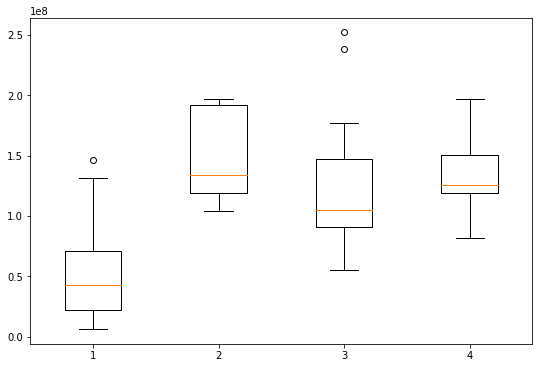

In [14]:
from itertools import compress

#Get all the trends:
songs_curve = []
for name in us_unique_song:
    trend = get_streams_and_position(name, stream_num, pos_num)
    v =standardize_serie(trend, normalize = False )
    songs_curve.append(v)
    
tot_streams = [sum(x) for x in songs_curve]  

k1 = list(compress(tot_streams, mm==0))
k2 = list(compress(tot_streams, mm==1))
k3 = list(compress(tot_streams, mm==2))
k4 = list(compress(tot_streams, mm==3))
print(f_oneway(k1,k2,k3,k4))

data_plot = [k1,k2,k3,k4]

fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(data_plot)
plt.show()

Actually, this time we manage to have a quite higher F-value (and a low p-value which is a strong evidence against the null hypothesis). Of course, the problem is that such measure can only be obtained after the first 150 days. Hence, you can not really do any sort of a-priori inference with this measure. Nontheless it is an interesting result.